In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json


In [16]:
with open('./lotRecords.json') as f:
    records = json.load(f)
flat_records = [dict(time=time, id=lot_id, status=status) for (time, lots) in records.items() for (lot_id, status) in lots.items()]
df = pd.DataFrame(flat_records)
df['time'] = pd.to_datetime(df['time'], unit='s').dt.round('30min')
df

,time,id,status
0,2023-04-15 17:00:00,99,available
1,2023-04-15 17:00:00,16,available
2,2023-04-15 17:00:00,94,/pics/ParkingIcons/sagur.png
3,2023-04-15 17:00:00,45,full
4,2023-04-15 17:00:00,24,available
...,...,...,...
9368,2023-04-17 20:00:00,69,na
9369,2023-04-17 20:00:00,56,active
9370,2023-04-17 20:00:00,132,na
9371,2023-04-17 20:00:00,88,na


In [17]:
names = pd.read_json('./lotNames.json', typ='series')
names

56      חניון אבולעפיה
64       חניון אחימאיר
110         חניון אלוף
73         חניון אלפסי
122        חניון אסותא
            ...       
68        חניון רפידים
69       חניון שלונסקי
42         חניון שרתון
84       חניון תל ברוך
45     חניון תל-נורדאו
Length: 91, dtype: object

In [18]:
df2 = pd.pivot(df, index='id', columns='time').status
no_status = ((df2 == 'na' )).all(axis='columns')
just_active = ((df2 == 'active' )).all(axis='columns')
lot_ids_without_status = set(df2[no_status | just_active].index)

In [21]:


# df2 = df2[~no_status & ~just_active]

time_columns = df2.columns

df2['grade'] = df2.apply(lambda row: row.map(dict(available=0, few=0.8, full=1, na=0, active=0)).sum(), axis='columns')
df2 = df2.sort_values(by=['grade'], ascending=False)
df2['name'] = names
df2 = df2.reindex(['name', 'grade'] + list(time_columns), axis='columns')

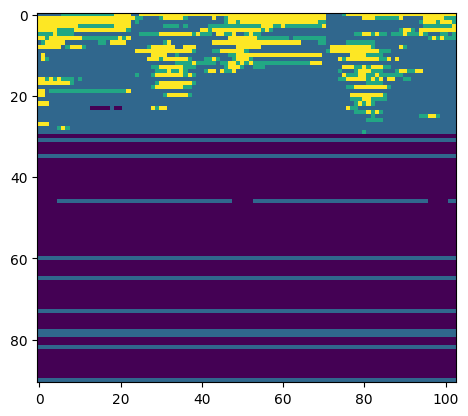

In [24]:

numeric_data = df2.drop(['grade', 'name'], axis='columns').applymap(lambda x: {'available':0, 'few': 0.8, 'full': 2, 'na': -1, 'active': -1, 'closed': -1}[x]).to_numpy()
plt.imshow(numeric_data)
plt.show()

In [32]:
nice_json_dict = dict()
for column in df2:
    if column in ['grade', 'name']:
        continue
    key = column.isoformat()
    values = df2[column].to_dict()
    nice_json_dict[key] = values

with open('parsed_lot_records.json', 'w')  as f:
    json.dump(nice_json_dict, f)

